In [1]:
import os
import re
import json
import glob
import string
import operator
import datetime
from collections import Counter
import itertools
import pandas as pd
import numpy as np
import networkx as nx

In [366]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import IPython.display
from IPython.display import display
plt.rc('font', serif='Times New Roman', size=11.0)
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'

# Word processing

In [77]:
def readlines_set(filepath):
    return set(line.strip() for line in open(filepath))

stopwords = {
    'postgresql': readlines_set('stopwords/postgresql-english.txt'),
    'nltk': readlines_set('stopwords/nltk-english.txt'),
    'google_1t': readlines_set('stopwords/google-1t.txt'),
    'alphabet': set(string.ascii_lowercase),
    'contraction_suffixes': {'s', 'm', 're', 've', 'll', 'd', 't'},
    'contraction_prefixes': {'don', 'isn'},
}
standard_stopwords_keys = ['google_1t', 'contraction_suffixes', 'contraction_prefixes']
standard_stopwords = set(stopword for key in standard_stopwords_keys for stopword in stopwords[key])
print '|standard_stopwords| =', len(standard_stopwords)

|standard_stopwords| = 206


In [333]:
def tokenize(s, stopwords=None):
    # normalize abbreviations to avoid stranded initials
    s = re.sub(r'(?:[A-Z]\.)+', lambda m: m.group(0).replace('.', ''), s)
    # normalize numbers to avoid 000 turning up as a significant token
    s = re.sub(r',(\d{3})\b', r'\1', s)
    # leave out non-linguistic content
    s = re.sub(r'\[(applause|crosstalk|laughter|inaudible|silence|booing|boos|cheers and applause)\]', ' ', s, re.I)
    # "justice" gets special treatment
    s = re.sub(r'Chief Justice', ' ', s)
    # replace all non-alphanumerics with spaces
    s = re.sub(r'[^\w]', ' ', s)
    for token in s.lower().strip().split():
        if stopwords is None or token not in stopwords:
            yield token

In [334]:
def speeches_to_counts(speeches, stopwords=None):
    tokens = [token for speech in speeches for token in tokenize(speech['text'], stopwords)]
    return Counter(tokens)

In [335]:
def normalize_counts(counts, smoothing=0.0):
    total = float(sum(counts.values()))
    return {k: (v + smoothing) / total for k, v in counts.items()}

In [336]:
def read_lines(filepaths):
    for filepath in filepaths:
        with open(filepath) as fp:
            for line in fp:
                yield line

In [337]:
def google_1t_frequencies(tokens):
    '''
    Assuming tokens are lower-case.
    '''
    remaining_tokens = set(tokens)
    google_1t_filepath_lower = os.path.expanduser(
        '~/corpora-public/Google-1T-unigrams-only/derivatives/vocab_cs_lower')
    with open(google_1t_filepath_lower) as fp:
        for line in fp:
            token, count_string = line.decode('utf-8').split('\t')
            if token in remaining_tokens:
                remaining_tokens.remove(token)
                yield token, float(count_string) / 1024908267229.0
            if len(remaining_tokens) == 0:
                # exit as soon as we're done
                break

## Speech loading

In [338]:
def read_inaugural():
    for line in read_lines(['../data/tapp/inaugurals.json']):
        yield json.loads(line)

In [339]:
pretrump_inaugural_speeches = [speech for speech in read_inaugural() 
                               if 'Trump' not in speech['author']]
pretrump_inaugural_counts = speeches_to_counts(pretrump_inaugural_speeches, standard_stopwords)
print '# tokens:', sum(pretrump_inaugural_counts.values())

# tokens: 58030


In [340]:
# prewar_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
#                                              if speech['timestamp'] < '1948-11-01')
# print '# tokens:', sum(prewar_inaugural_counts.values())

In [341]:
postwar_pretrump_inaugural_speeches = [speech for speech in read_inaugural() 
                                       if speech['timestamp'] > '1948-11-01' 
                                       and 'Trump' not in speech['author']]
postwar_pretrump_inaugural_counts = speeches_to_counts(postwar_pretrump_inaugural_speeches, standard_stopwords)
print '# tokens:', sum(postwar_pretrump_inaugural_counts.values())
# print 'top 50 types:', postwar_pretrump_inaugural_counts.most_common(50)

# tokens: 14589


In [342]:
def read_election2016_speeches():
    for line in read_lines(['../data/tapp/election2016.json']):
        speech = json.loads(line)
        title = speech['title']
        if 'Press Release' not in title and 'Statement by' not in title:
            yield speech

In [343]:
trump_election2016_speeches = [speech for speech in read_election2016_speeches()
                               if speech['author'] == 'Donald J. Trump']
trump_election2016_counts = speeches_to_counts(trump_election2016_speeches, standard_stopwords)
print '# tokens:', sum(trump_election2016_counts.values())
# print 'top 50 types:', trump_election2016_counts.most_common(50)

# tokens: 72940


In [344]:
trump_inaugural_counts = speeches_to_counts(trump_inaugural_speeches, standard_stopwords)
print '|trump_inaugural_counts| =', sum(trump_inaugural_counts.values())

|trump_inaugural_counts| = 622


# Proportion of speech allocated to specific word groups

In [553]:
synsets = [
#     ('freedom\nliberty\nrights\npublic', ['freedom', 'freedoms', 'liberty', 'liberties', 'rights', 'public']),
    ('freedom(s)', ['freedom', 'freedoms']),
    ('peace(ful)', ['peace', 'peaceful']),
    ('justice', ['justice']),
    ('libert(y/ies)', ['liberty', 'liberties']),
    #('freedom(s)+\nliberty(ies)', ['freedom', 'freedoms', 'liberty', 'liberties']),
    ('rights', ['rights']),
    #('right(s)', ['right', 'rights']),
#     ('america(n(s))', ['america', 'american', 'americans']),
#     ('job(s)', ['job', 'jobs']),
    #('constitution', ['constitution']),
    #('principle(s/d)', ['principle', 'principles', 'principled']),
#     ('immigrate(ion)', ['immigrate', 'immigrates', 'immigrated', 'immigrating', 'immigration']),
    #('russia/ussr', ['russia', 'ussr']),
    #('china', ['china']),
#     ('great(er/est)', ['great', 'greater', 'greatest']),
    ('china-et-al', map(str.lower, ["China", "Mexico", "military", "hell", 
                     "Iran", "tough", "disaster" "horrible", 
                     "worst", "strong", "ISIS", "immigration", "border", "borders"])),
    ('trump\ndonald', ['trump', 'donald']),
    ('trump', ['trump']),
    ('donald', ['donald']),
]

In [554]:
def proportional_usage(tokens, counts):
    maximum = sum(counts.values())
    usage = sum(counts.get(token, 0) for token in tokens)
    return float(usage) / float(maximum)

def synset_proportional_usages(synsets, counts):
    return {synset_name: proportional_usage(synset_tokens, counts) for synset_name, synset_tokens in synsets}

In [555]:
def iter_usages():
    sources = [#('All pre-Trump inaugural speeches', pretrump_inaugural_counts),
               #('Pre-war inaugural speeches', prewar_inaugural_counts),
               ('Post-war, pre-Trump inaugural addresses', postwar_pretrump_inaugural_counts),
               ('Trump campaign speeches', trump_election2016_counts),
               ('Trump inaugural address', trump_inaugural_counts)
    ]
    for source_name, source_counts in sources:
        for synset_name, synset_tokens in synsets:
            usage = proportional_usage(synset_tokens, source_counts)
            yield dict(source=source_name, synset=synset_name, usage=usage)

In [556]:
df_usages = pd.DataFrame.from_dict(iter_usages())

In [557]:
df_usages_t = df_usages.pivot(index='synset', columns='source', values='usage')
df_usages_t = df_usages_t.reindex([name for name, _ in synsets])
df_usages_t

source,"Post-war, pre-Trump inaugural addresses",Trump campaign speeches,Trump inaugural address
synset,,,
freedom(s),0.008568,0.000288,0.001608
peace(ful),0.007403,0.000768,0.001608
justice,0.001919,0.000905,0.000000
libert(y/ies),0.003153,0.000178,0.000000
rights,0.001508,0.000329,0.000000
china-et-al,0.002947,0.014820,0.011254
trump\ndonald,0.000000,0.006526,0.000000
trump,0.000000,0.004456,0.000000
donald,0.000000,0.002070,0.000000


In [558]:
1/df_usages_t

source,"Post-war, pre-Trump inaugural addresses",Trump campaign speeches,Trump inaugural address
synset,,,
freedom(s),116.712000,3473.333333,622.000000
peace(ful),135.083333,1302.500000,622.000000
justice,521.035714,1105.151515,inf
libert(y/ies),317.152174,5610.769231,inf
rights,663.136364,3039.166667,inf
china-et-al,339.279070,67.474561,88.857143
trump\ndonald,inf,153.235294,inf
trump,inf,224.430769,inf
donald,inf,483.046358,inf


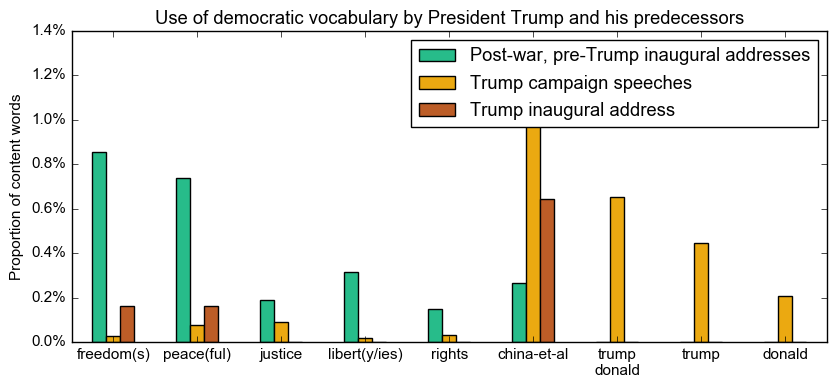

In [391]:
ax = df_usages_t.plot(figsize=(8.5, 4), kind='bar', color=['#27BC8A', '#EBA911', '#BC5D27'])
ax.xaxis.label.set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.01%}'.format(y)))
legend = ax.legend()
legend.set_title(None)
plt.xticks(rotation=0)
plt.ylabel('Proportion of content words')
plt.title('Use of democratic vocabulary by President Trump and his predecessors')
plt.tight_layout()
# plt.savefig('democratic_vocabulary_proportions.pdf')

# Inaugural address word count

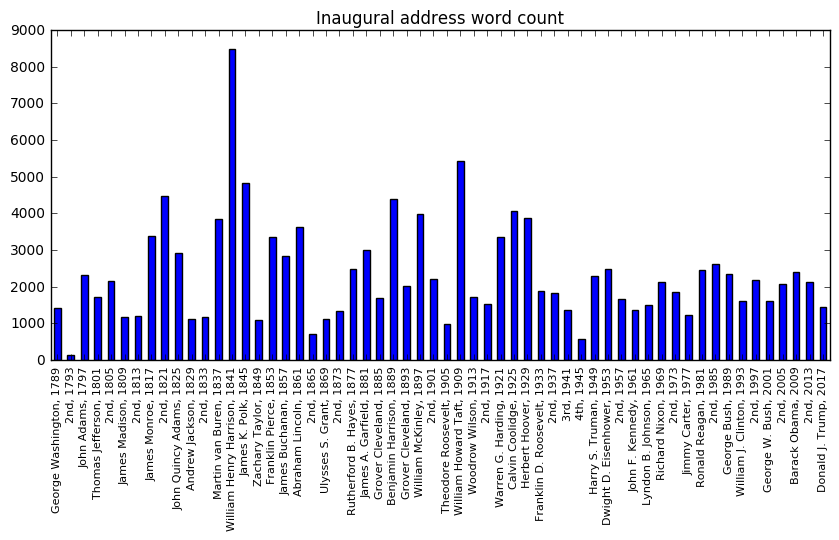

In [34]:
ordinal_mapping = {'First': '1st', 'Second': '2nd', 'Third': '3rd', 'Fourth': '4th'}
def get_inaugural_ticklabels(df):
    last_author = None
    for _, speech in df.iterrows():
        author = speech.author
        title = ordinal_mapping[speech.title.split()[0]] if author == last_author else author
        last_author = author
        yield title + ', ' + str(speech.timestamp.year)
keep_keys = ['title', 'author', 'timestamp']
df = pd.DataFrame.from_dict(dict({key: speech[key] for key in keep_keys}.items() + 
                                 [('word_count', len(list(tokenize(speech['text']))))])
                             for speech in read_inaugural())
df['timestamp'] = pd.to_datetime(df.timestamp)
# draw plot for all inaugurals
ax = df.plot(x='timestamp', y='word_count', figsize=(8.5, 5.5), kind='bar', legend=False, 
             title="Inaugural address word count")
ticklabels = list(get_inaugural_ticklabels(df))
for label in ax.get_xticklabels():
    label.set_fontsize(8)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig('inaugural_word_count.pdf')

# Surname mentions in inaugural speeches

In [35]:
pd.options.display.max_rows = 7
pd.options.display.max_columns = 7

In [36]:
def iter_surnames(speeches, surnames):
    for speech in speeches:
        text = speech['text']
        title = speech['author'] + ': ' + speech['title']
        for surname in surnames:
            surname_count = text.count(surname)
            yield dict(title=title, surname=surname, count=surname_count)

In [39]:
speeches = list(read_inaugural())
surnames_list = [speech['author'].split()[-1] for speech in speeches]
surnames = set(surnames_list)

In [40]:
titles_ordered = [speech['author'] + ': ' + speech['title'] for speech in speeches]
surnames_ordered = sorted(list(surnames), key=surnames_list.index)

In [41]:
df_surnames = pd.DataFrame.from_dict(iter_surnames(speeches, surnames))
df_surnames

,count,surname,title
0,0,Wilson,George Washington: Inaugural Address
1,0,Jackson,George Washington: Inaugural Address
2,0,Buren,George Washington: Inaugural Address
...,...,...,...
2027,0,Truman,Donald J. Trump: Inaugural Address
2028,0,Polk,Donald J. Trump: Inaugural Address
2029,0,Monroe,Donald J. Trump: Inaugural Address


In [42]:
df_xtab = df_surnames.pivot(index='title', columns='surname', values='count')
# reorder columns
df_xtab = df_xtab[surnames_ordered]
# reorder rows
df_xtab = df_xtab.reindex(titles_ordered)
df_xtab

surname,Washington,Adams,Jefferson,...,Clinton,Obama,Trump
title,,,,,,,
George Washington: Inaugural Address,0,0,0,...,0,0,0
George Washington: Second Inaugural Address,0,0,0,...,0,0,0
John Adams: Inaugural Address,0,0,0,...,0,0,0
...,...,...,...,...,...,...,...
Barack Obama: Inaugural Address,0,0,0,...,0,0,0
Barack Obama: Second Inaugural Address,0,0,0,...,0,0,0
Donald J. Trump: Inaugural Address,2,0,0,...,1,3,0


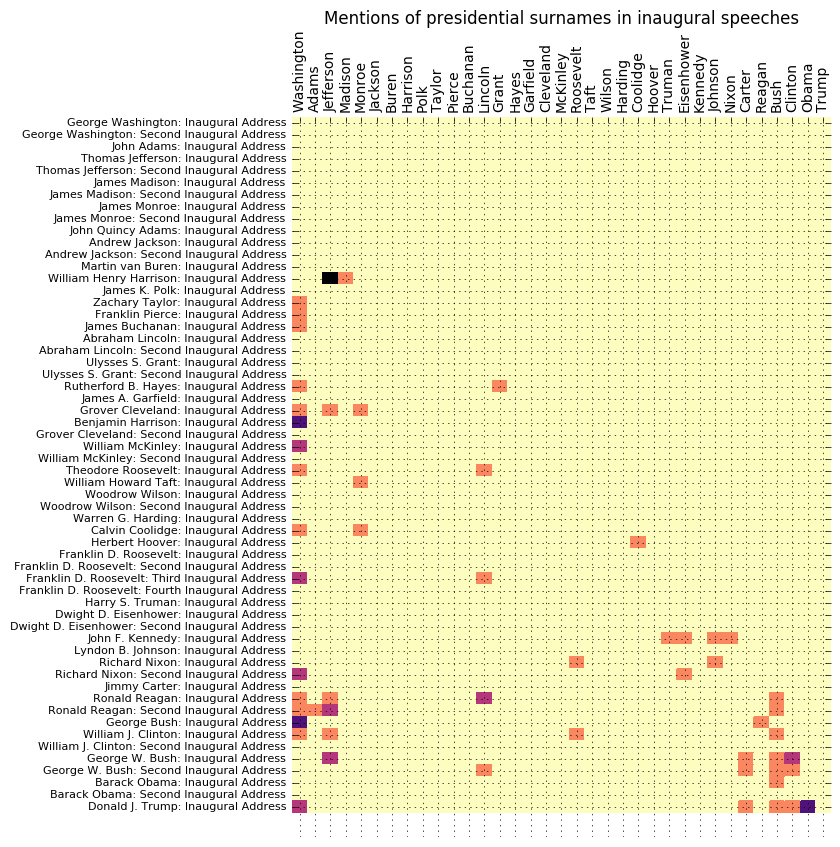

In [43]:
# based on https://stackoverflow.com/a/16124677
plt.figure(figsize=(8.5, 8.5))
plt.pcolor(df_xtab, cmap=plt.cm.magma_r)
ax = plt.axes()
ax.set_frame_on(False)
ax.set_yticks(np.arange(df_xtab.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(df_xtab.shape[1]) + 0.5, minor=False)
# flip x-ticks/labels to top
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
# ax.xaxis.tick_top()
plt.xticks(rotation=90)
# set the x/y tick labels
ax.set_xticklabels(df_xtab.columns, minor=False)
ax.set_yticklabels(df_xtab.index, minor=False)
ax.grid(True)
# better label fit
for label in ax.get_yticklabels():
    label.set_fontsize(8)
plt.title('Mentions of presidential surnames in inaugural speeches', y=1.12)
plt.tight_layout()
# plt.savefig('inaugural_surnames.pdf')

# Self mentions in speeches


# Significant others

In [15]:
def iter_counts(groups, vocab, smoothing=0):
    '''
    groups: a list of (group_name, group_counts) pairs
    vocab: a set/list of tokens
    '''
    for group_name, group_counts in groups:
        for word in vocab:
            yield dict(group=group_name, word=word, word_count=group_counts.get(word, 0) + smoothing)

In [16]:
def set_proportion(df):
    '''
    This seems ugly as the argument to pd.GroupedDataSeries.apply(), but it works
    '''
    df['proportion'] = df['word_count'] / np.sum(df['word_count'])
    return df

In [491]:
pd.options.display.max_columns = 10
pd.options.display.max_rows = 10

In [499]:
# postwar pre-trump
inaugural_speeches = [speech for speech in read_inaugural() 
                      if speech['timestamp'] > '1948-11-01' and 'Trump' not in speech['author']]
# all pre-trump
# inaugural_speeches = [speech for speech in read_inaugural() if 'Trump' not in speech['author']]
print '|inaugural_speeches| =', len(inaugural_speeches)
inaugural_counts = speeches_to_counts(inaugural_speeches, standard_stopwords)
print '|inaugural_counts| =', sum(inaugural_counts.values())

|inaugural_speeches| = 17
|inaugural_counts| = 14589


In [503]:
trump_inaugural_speeches  = [speech for speech in read_inaugural() 
                             if 'Trump' in speech['author']]
trump_election2016_speeches = [speech for speech in read_election2016_speeches()
                               if speech['author'] == 'Donald J. Trump']
# trump_speeches = trump_inaugural_speeches + trump_election2016_speeches
trump_speeches = trump_inaugural_speeches
print '|trump_speeches| =', len(trump_speeches)
trump_counts = speeches_to_counts(trump_speeches, standard_stopwords)
print '|trump_counts| =', sum(trump_counts.values())

|trump_speeches| = 1
|trump_counts| = 622


In [504]:
groups = [('inaugural', inaugural_counts),
          ('trump', trump_counts)]

In [505]:
full_vocab = set([token for _, counts in groups for token in counts.keys()]) # 12219
print '|full_vocab| =', len(full_vocab)

|full_vocab| = 4091


In [506]:
k = 250
smoothing = 1.0

In [507]:
df_counts = pd.DataFrame.from_dict(iter_counts(groups, full_vocab, smoothing)).groupby('group').apply(set_proportion)
# df_counts

In [508]:
# derive more condensed vocabulary
df_proportions_merged = df_counts.groupby('word').agg({'proportion': sum})
# df_proportions_merged.sort_values('proportion', ascending=False)

In [509]:
vocab = set(df_proportions_merged.nlargest(k, 'proportion').index)
print '|vocab| =', len(vocab)

|vocab| = 250


In [510]:
print ' '.join(vocab)

less years course human earth fear longer children begin whose factories thank justice character young vision labor better continue nor rich citizen born merely hope good greater government far between nation cannot know words hands schools world dreams meaning dignity resolve beginning like success countries always celebrate bless honor common small done security challenge generations borders right old pledge people generation national hard principles past society economic follow beyond ourselves best living destiny lead god liberty weapons protected capital progress speak cause public full jobs power problems men confidence free communism poverty others ask strong yes abroad change knowledge faith great freedom citizens equal against times turn american journey place stand action military special think first mr love simple demands washington system down alone everyone americans another carry force millions city story law voices wealth service become union opportunity political two lo

In [511]:
# could take a second depending on how rare the vocab is
# vocab_1t_frequencies = dict(google_1t_frequencies(vocab))

In [512]:
# recount with condensed vocab
df_counts = pd.DataFrame.from_dict(iter_counts(groups, vocab, smoothing)).groupby('group').apply(set_proportion)
# df_counts.sort_values('proportion', ascending=False)

In [513]:
# trump_counts = df_counts[df_counts.group=='trump']

# trump_counts.sort_values('proportion', ascending=False).reset_index(drop=True)

# trump_counts_reordered = trump_counts.sort_values('proportion', ascending=False).reset_index(drop=True)
# trump_counts_reordered[trump_counts_reordered.word=='donald']

In [514]:
inaugural_counts = df_counts[df_counts.group=='inaugural']
inaugural_counts = inaugural_counts.sort_values('proportion', ascending=False).reset_index(drop=True)
pd.options.display.max_rows = 100
inaugural_counts

,group,word,word_count,proportion
0,inaugural,world,199.0,0.030648
1,inaugural,people,150.0,0.023102
2,inaugural,america,147.0,0.022640
3,inaugural,nation,131.0,0.020176
4,inaugural,freedom,125.0,0.019252
5,inaugural,time,104.0,0.016017
6,inaugural,peace,98.0,0.015093
7,inaugural,government,94.0,0.014477
8,inaugural,free,80.0,0.012321
9,inaugural,work,76.0,0.011705


### Oh boy word clouds

In [466]:
from wordcloud import WordCloud

In [467]:
def display_frequencies_wordcloud(frequencies):
    #wordCloud = WordCloud(max_font_size=40)
    wordCloud = WordCloud()
    wordCloud_generated = wordCloud.generate_from_frequencies(frequencies)
    plt.imshow(wordCloud_generated)
    plt.axis('off')

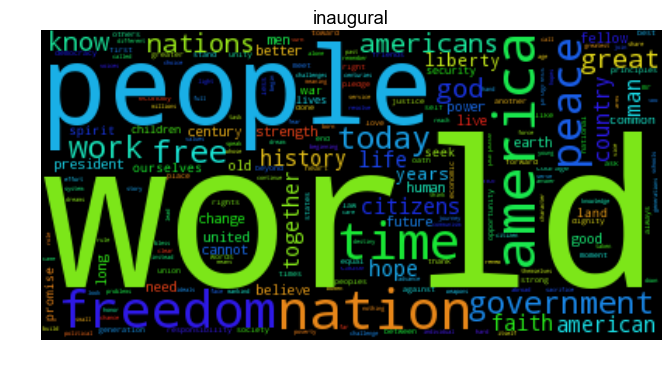

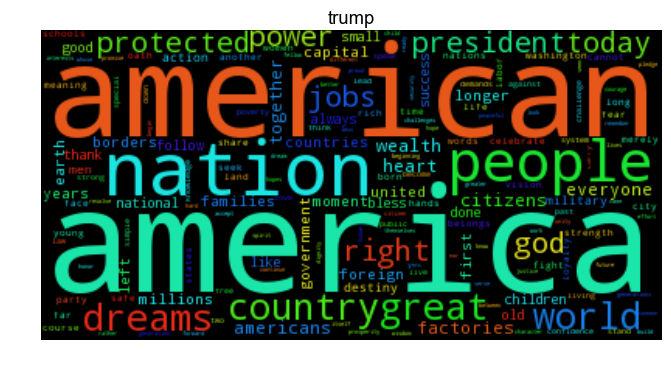

In [468]:
for group, group_df in df_counts.groupby('group'):
    plt.figure(figsize=(8.5, 4))
    display_frequencies_wordcloud(zip(group_df.word, group_df.proportion))    
    plt.title(group)

### Back to business

That's nice to look at, but we also want some consistent ordering of relative inaugural-ness vs. Trumpery.

We can get that just by dividing one over the other. We'll use Trump proportion / Inaugural proportion, so higher values will indicate higher Trumpery.

In [515]:
df_proportions = df_counts.pivot(index='word', columns='group', values='proportion')
df_proportions['trump/inaugural'] = df_proportions.trump / df_proportions.inaugural

The ratio produces the desired ordering, but it ranges from very tiny values,
to 1 (meaning similar usage), to arbitrarily large values.

As we'll seen in a second with the (log-log) scatter plot, what we want is a sort of radial / angular measure.
The words around the y=x diagonal see similar usage, with the words in the upper-left being more Trump-ish and the words in the lower-right being more Inaugural.
Yay trigonometry!

In [516]:
#rad = np.arctan(df_proportions['trump/inaugural'])
rad = np.arctan2(df_proportions.trump, df_proportions.inaugural)
# re-map from [0, pi/2] to [-1, 1]
df_proportions[u'trump°inaugural'] = rad * (4.0 / np.pi) + -1.0

In [517]:
df_proportions = df_proportions.sort_values(u'trump°inaugural')

In [518]:
# df_proportions['google_1t'] = df_proportions.index.map(lambda k: vocab_1t_frequencies.get(k, 1))

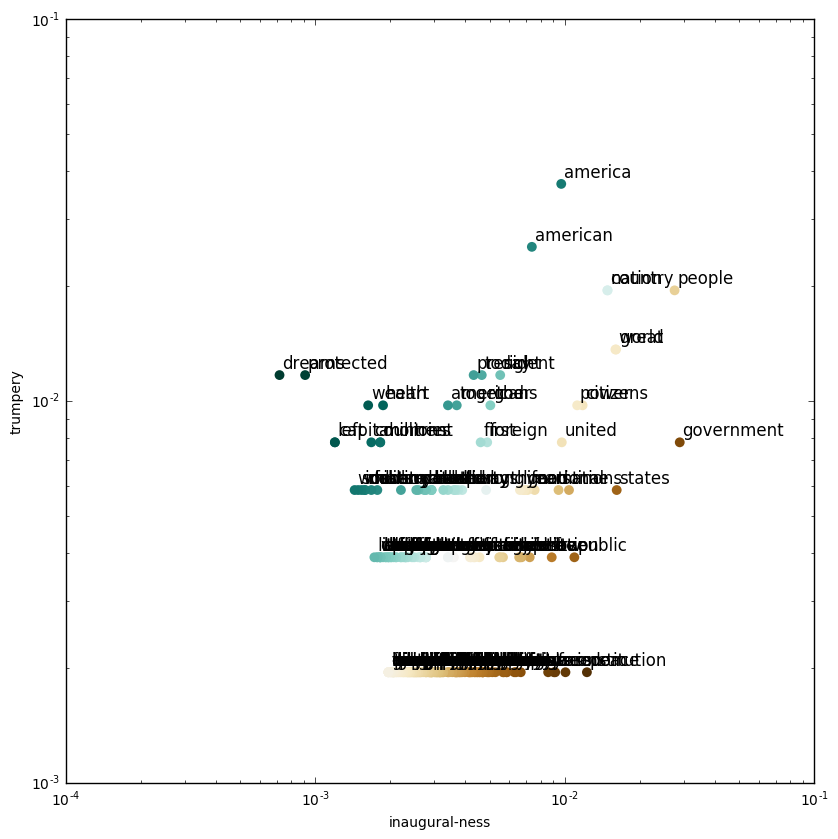

In [106]:
plt.figure(figsize=(8.5, 8.5))
x = df_proportions['inaugural']
plt.xscale('log')
# plt.xlabel('global frequency of word (based on Google 1T unigrams)')
plt.xlabel('inaugural-ness')
y = df_proportions['trump']
plt.yscale('log')
# plt.ylabel(u'relative\n<- inauguralness or Trumpery ->')
plt.ylabel('trumpery')
# points
plt.scatter(x, y, c=df_proportions[u'trump°inaugural'], cmap=plt.cm.BrBG, linewidths=0, s=50)
for label, x, y in zip(df_proportions.index, x, y):
    plt.annotate(label, xy=(x, y), xytext=(2, 2),
                 size='large',
                 textcoords='offset points', ha='left', va='bottom')
plt.tight_layout()

That's neat, but kind of a mess. More directly, we can look at the actual ranking.

In [521]:
pd.options.display.max_rows = 20
df_proportions

group,inaugural,trump,trump/inaugural,trump°inaugural
word,,,,
freedom,0.019252,0.001767,0.091774,-0.883476
peace,0.015093,0.001767,0.117058,-0.851632
know,0.009703,0.001767,0.182091,-0.770667
history,0.009241,0.001767,0.191196,-0.759465
man,0.008779,0.001767,0.201258,-0.747128
hope,0.008163,0.001767,0.216448,-0.728597
faith,0.007393,0.001767,0.238994,-0.701306
liberty,0.007085,0.001767,0.249385,-0.688820
century,0.006469,0.001767,0.273136,-0.660512


Still, it's a lot of numbers. Let's discretize.

### Categories of trumpiness 

Having an ordering on the words means we can bin the words in discrete chunks.

The `trump/inaugural` ratio is monotonic with the `trump°inaugural` column, but since the latter has a nicer scale, we'll use it.

In [522]:
# equal bin widths:
# _, binedges = np.histogram(df_proportions[u'trump°inaugural'], bins=7)
# equal bin depths:
binedges = np.percentile(df_proportions[u'trump°inaugural'], np.linspace(0, 100, 8))

In [523]:
binnames = ['Most presidential', '2nd-most presidential', '3rd-most presidential',
            'Neutral', 
            '3rd-most Trumpy', '2nd-most Trumpy', 'Most Trumpy']
assignments = np.digitize(df_proportions[u'trump°inaugural'], binedges[:-1]) - 1
df_proportions['trumpiness'] = np.array(binnames)[assignments]

In [524]:
trumpiness_bins = [(name, pd.Series(list(group_df.sort_values(u'trump°inaugural', ascending=True).word)))
                   for name, group_df in df_proportions.reset_index().groupby('trumpiness')]
df_bins = pd.DataFrame(dict(trumpiness_bins)).fillna('')
df_bins = df_bins[binnames]

In [525]:
pd.options.display.max_rows = 40
df_bins

,Most presidential,2nd-most presidential,3rd-most presidential,Neutral,3rd-most Trumpy,2nd-most Trumpy,Most Trumpy
0,freedom,friends,spirit,instead,unity,thank,merely
1,peace,beyond,resolve,arms,law,came,right
2,know,mr,hard,clear,against,challenge,face
3,history,dignity,individual,task,courage,system,destiny
4,man,less,values,taken,great,oath,rather
5,hope,nations,join,continue,united,like,wisdom
6,faith,meet,promise,political,build,moment,living
7,liberty,end,mankind,voices,states,down,interests
8,century,government,reach,role,past,look,demands
9,human,opportunity,story,communism,young,born,vision


# Focus

How about we focus in on a couple specific words.

In [526]:
# pd.options.display.max_rows = 200
# df_proportions.sort_values(u'trump°inaugural')

In [541]:
ranked_words = list(df_proportions.sort_values(u'trump°inaugural').index)
inaugural_20 = ranked_words[:20]
print 'inaugural_20:', ', '.join(inaugural_20)
trump_20 = ranked_words[-20:]
print 'trump_20:', ', '.join(trump_20)

inaugural_20: freedom, peace, know, history, man, hope, faith, liberty, century, human, free, believe, need, change, work, time, better, ourselves, war, common
trump_20: washington, capital, countries, wealth, military, party, follow, dreams, loyalty, city, fight, belongs, safe, left, jobs, foreign, factories, everyone, borders, protected


In [542]:
extreme_40 = set(trump_20 + inaugural_20)

In [560]:
keywords = {'freedom', 'freedoms', 'liberty', 'liberties', 'rights', 
            'america', 'american', 'world', 'borders', 'protected'}

In [544]:
from adjustText import adjust_text

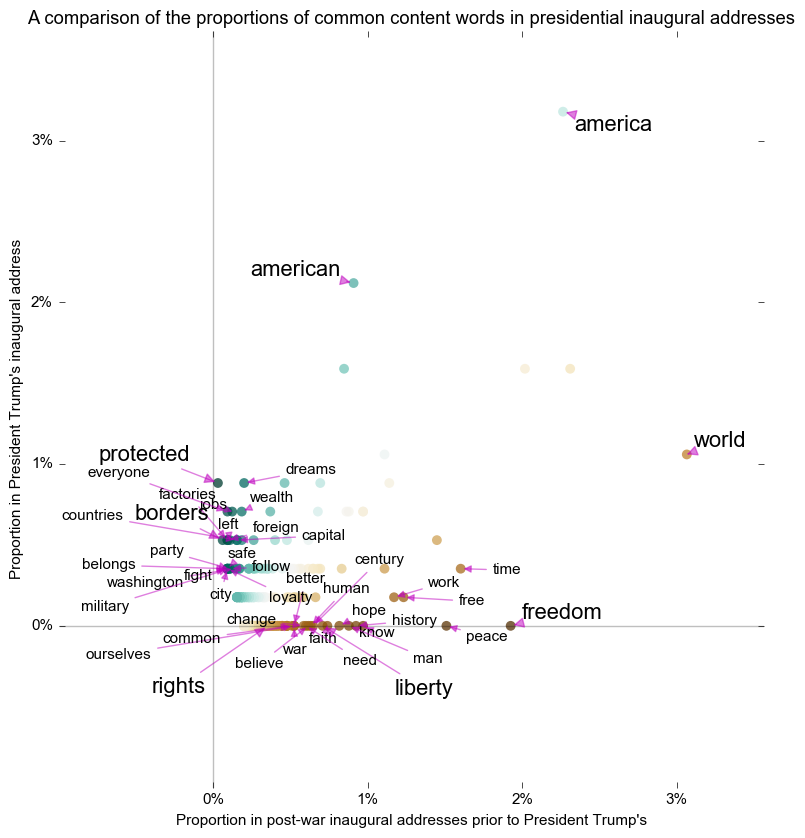

In [561]:
plt.figure(figsize=(8.5, 8.5))
xs = df_proportions.inaugural
plt.xlabel("Proportion in post-war inaugural addresses prior to President Trump's")
ys = df_proportions.trump - min(df_proportions.trump)
plt.ylabel("Proportion in President Trump's inaugural address")
# points
plt.scatter(xs, ys, 
            c=df_proportions[u'trump°inaugural'], cmap=plt.cm.BrBG,
            linewidths=0, s=50, alpha=0.75)
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
# labels
annotations = []
for label, x, y in zip(df_proportions.index, xs, ys):
    if label in (extreme_40 | keywords):
        size = 'x-large' if label in keywords else None
        annotation = plt.text(x, y, label, size=size)
        annotations.append(annotation)
# adjustments
adjust_text(annotations, force_text=0.2, arrowprops=dict(arrowstyle="-|>", color='m', alpha=0.5))
plt.xticks(np.arange(0, 0.04, 0.01))
plt.yticks(np.arange(0, 0.04, 0.01))
margin = 0.005
plt.xlim(-2.0*margin, max(xs) + margin)
plt.ylim(-2.0*margin, max(ys) + margin)
plt.vlines(0, *plt.ylim(), alpha=0.25)
plt.hlines(0, *plt.ylim(), alpha=0.25)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.title('A comparison of the proportions of common content words in presidential inaugural addresses')
plt.tight_layout()
plt.savefig('inaugural_postwar_scatter_labeled.pdf')